In [3]:
# Download data and extract into path/data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

--2019-11-15 09:27:43--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.41.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.41.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  4.65MB/s    in 75s     

2019-11-15 09:28:59 (4.33 MB/s) - ‘data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  data/train-test-data.zip
   creating: data/test/
  inflating: data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: data/test/Abdullah_Gul_10.jpg  
  

  inflating: data/test/Baburam_Bhattari_30.jpg  
  inflating: data/test/Baburam_Bhattari_31.jpg  
  inflating: data/test/Barbara_Bodine_00.jpg  
  inflating: data/test/Barbara_Bodine_01.jpg  
  inflating: data/test/Barbara_Bodine_20.jpg  
  inflating: data/test/Barbara_Bodine_21.jpg  
  inflating: data/test/Barbara_Bodine_40.jpg  
  inflating: data/test/Barbara_Bodine_41.jpg  
  inflating: data/test/Barbara_Bodine_50.jpg  
  inflating: data/test/Barbara_Bodine_51.jpg  
  inflating: data/test/Barbara_Boxer_10.jpg  
  inflating: data/test/Barbara_Boxer_11.jpg  
  inflating: data/test/Barbara_Boxer_40.jpg  
  inflating: data/test/Barbara_Boxer_41.jpg  
  inflating: data/test/Barbara_Boxer_50.jpg  
  inflating: data/test/Barbara_Boxer_51.jpg  
  inflating: data/test/Barbara_Walters_00.jpg  
  inflating: data/test/Barbara_Walters_01.jpg  
  inflating: data/test/Barbara_Walters_20.jpg  
  inflating: data/test/Barbara_Walters_21.jpg  
  inflating: data/test/Barbara_Walters_40.jpg  
  inflatin

  inflating: data/test/Celso_Amorim_41.jpg  
  inflating: data/test/Celso_Amorim_50.jpg  
  inflating: data/test/Celso_Amorim_51.jpg  
  inflating: data/test/Celso_Lafer_00.jpg  
  inflating: data/test/Celso_Lafer_01.jpg  
  inflating: data/test/Celso_Lafer_10.jpg  
  inflating: data/test/Celso_Lafer_11.jpg  
  inflating: data/test/Celso_Lafer_20.jpg  
  inflating: data/test/Celso_Lafer_21.jpg  
  inflating: data/test/Chadha_Gurinder_10.jpg  
  inflating: data/test/Chadha_Gurinder_11.jpg  
  inflating: data/test/Chadha_Gurinder_20.jpg  
  inflating: data/test/Chadha_Gurinder_21.jpg  
  inflating: data/test/Chadha_Gurinder_50.jpg  
  inflating: data/test/Chadha_Gurinder_51.jpg  
  inflating: data/test/Charles_Bronson_00.jpg  
  inflating: data/test/Charles_Bronson_01.jpg  
  inflating: data/test/Charles_Bronson_10.jpg  
  inflating: data/test/Charles_Bronson_11.jpg  
  inflating: data/test/Charles_Bronson_50.jpg  
  inflating: data/test/Charles_Bronson_51.jpg  
  inflating: data/test/Ch

  inflating: data/test/Colin_Powell_10.jpg  
  inflating: data/test/Colin_Powell_11.jpg  
  inflating: data/test/Colin_Powell_40.jpg  
  inflating: data/test/Colin_Powell_41.jpg  
  inflating: data/test/Colin_Powell_50.jpg  
  inflating: data/test/Colin_Powell_51.jpg  
  inflating: data/test/Conan_OBrien_00.jpg  
  inflating: data/test/Conan_OBrien_01.jpg  
  inflating: data/test/Conan_OBrien_10.jpg  
  inflating: data/test/Conan_OBrien_11.jpg  
  inflating: data/test/Conan_OBrien_50.jpg  
  inflating: data/test/Conan_OBrien_51.jpg  
  inflating: data/test/Condoleezza_Rice_10.jpg  
  inflating: data/test/Condoleezza_Rice_11.jpg  
  inflating: data/test/Condoleezza_Rice_20.jpg  
  inflating: data/test/Condoleezza_Rice_21.jpg  
  inflating: data/test/Condoleezza_Rice_30.jpg  
  inflating: data/test/Condoleezza_Rice_31.jpg  
  inflating: data/test/Condoleezza_Rice_40.jpg  
  inflating: data/test/Condoleezza_Rice_41.jpg  
  inflating: data/test/Connie_Chung_20.jpg  
  inflating: data/test/

  inflating: data/test/Eliane_Karp_30.jpg  
  inflating: data/test/Eliane_Karp_31.jpg  
  inflating: data/test/Eliane_Karp_40.jpg  
  inflating: data/test/Eliane_Karp_41.jpg  
  inflating: data/test/Elijah_Wood_00.jpg  
  inflating: data/test/Elijah_Wood_01.jpg  
  inflating: data/test/Elijah_Wood_10.jpg  
  inflating: data/test/Elijah_Wood_11.jpg  
  inflating: data/test/Elijah_Wood_30.jpg  
  inflating: data/test/Elijah_Wood_31.jpg  
  inflating: data/test/Eliza_Dushku_00.jpg  
  inflating: data/test/Eliza_Dushku_01.jpg  
  inflating: data/test/Eliza_Dushku_10.jpg  
  inflating: data/test/Eliza_Dushku_11.jpg  
  inflating: data/test/Eliza_Dushku_20.jpg  
  inflating: data/test/Eliza_Dushku_21.jpg  
  inflating: data/test/Eliza_Dushku_30.jpg  
  inflating: data/test/Eliza_Dushku_31.jpg  
  inflating: data/test/Elizabeth_Dole_00.jpg  
  inflating: data/test/Elizabeth_Dole_01.jpg  
  inflating: data/test/Elizabeth_Dole_10.jpg  
  inflating: data/test/Elizabeth_Dole_11.jpg  
  inflating:

  inflating: data/test/Francis_Collins_20.jpg  
  inflating: data/test/Francis_Collins_21.jpg  
  inflating: data/test/Francis_Collins_40.jpg  
  inflating: data/test/Francis_Collins_41.jpg  
  inflating: data/test/Frank_Beamer_00.jpg  
  inflating: data/test/Frank_Beamer_01.jpg  
  inflating: data/test/Frank_Beamer_20.jpg  
  inflating: data/test/Frank_Beamer_21.jpg  
  inflating: data/test/Frank_Beamer_30.jpg  
  inflating: data/test/Frank_Beamer_31.jpg  
  inflating: data/test/Frank_Caliendo_10.jpg  
  inflating: data/test/Frank_Caliendo_11.jpg  
  inflating: data/test/Frank_Caliendo_30.jpg  
  inflating: data/test/Frank_Caliendo_31.jpg  
  inflating: data/test/Frank_Caliendo_40.jpg  
  inflating: data/test/Frank_Caliendo_41.jpg  
  inflating: data/test/Frank_Caliendo_50.jpg  
  inflating: data/test/Frank_Caliendo_51.jpg  
  inflating: data/test/Frank_Keating_30.jpg  
  inflating: data/test/Frank_Keating_31.jpg  
  inflating: data/test/Frank_Keating_40.jpg  
  inflating: data/test/F

  inflating: data/test/Jake_Gyllenhaal_51.jpg  
  inflating: data/test/Jake_Plummer_20.jpg  
  inflating: data/test/Jake_Plummer_21.jpg  
  inflating: data/test/Jake_Plummer_40.jpg  
  inflating: data/test/Jake_Plummer_41.jpg  
  inflating: data/test/Jake_Plummer_50.jpg  
  inflating: data/test/Jake_Plummer_51.jpg  
  inflating: data/test/James_Carville_00.jpg  
  inflating: data/test/James_Carville_01.jpg  
  inflating: data/test/James_Carville_10.jpg  
  inflating: data/test/James_Carville_11.jpg  
  inflating: data/test/James_Carville_30.jpg  
  inflating: data/test/James_Carville_31.jpg  
  inflating: data/test/James_Carville_50.jpg  
  inflating: data/test/James_Carville_51.jpg  
  inflating: data/test/James_Cunningham_00.jpg  
  inflating: data/test/James_Cunningham_01.jpg  
  inflating: data/test/James_Cunningham_20.jpg  
  inflating: data/test/James_Cunningham_21.jpg  
  inflating: data/test/James_Cunningham_30.jpg  
  inflating: data/test/James_Cunningham_31.jpg  
  inflating:

  inflating: data/test/Kit_Bond_50.jpg  
  inflating: data/test/Kit_Bond_51.jpg  
  inflating: data/test/Kristen_Breitweiser_00.jpg  
  inflating: data/test/Kristen_Breitweiser_01.jpg  
  inflating: data/test/Kristen_Breitweiser_10.jpg  
  inflating: data/test/Kristen_Breitweiser_11.jpg  
  inflating: data/test/Kristen_Breitweiser_20.jpg  
  inflating: data/test/Kristen_Breitweiser_21.jpg  
  inflating: data/test/Kristen_Breitweiser_50.jpg  
  inflating: data/test/Kristen_Breitweiser_51.jpg  
  inflating: data/test/Kristin_Chenoweth_10.jpg  
  inflating: data/test/Kristin_Chenoweth_11.jpg  
  inflating: data/test/Kristin_Chenoweth_40.jpg  
  inflating: data/test/Kristin_Chenoweth_41.jpg  
  inflating: data/test/Kristin_Chenoweth_50.jpg  
  inflating: data/test/Kristin_Chenoweth_51.jpg  
  inflating: data/test/Kristin_Scott_10.jpg  
  inflating: data/test/Kristin_Scott_11.jpg  
  inflating: data/test/Kristin_Scott_40.jpg  
  inflating: data/test/Kristin_Scott_41.jpg  
  inflating: data/

  inflating: data/test/Liu_Ye_01.jpg  
  inflating: data/test/Liu_Ye_10.jpg  
  inflating: data/test/Liu_Ye_11.jpg  
  inflating: data/test/Liu_Ye_20.jpg  
  inflating: data/test/Liu_Ye_21.jpg  
  inflating: data/test/Liu_Ye_50.jpg  
  inflating: data/test/Liu_Ye_51.jpg  
  inflating: data/test/Loretta_Lynn_Harper_00.jpg  
  inflating: data/test/Loretta_Lynn_Harper_01.jpg  
  inflating: data/test/Loretta_Lynn_Harper_30.jpg  
  inflating: data/test/Loretta_Lynn_Harper_31.jpg  
  inflating: data/test/Loretta_Lynn_Harper_40.jpg  
  inflating: data/test/Loretta_Lynn_Harper_41.jpg  
  inflating: data/test/Loretta_Lynn_Harper_50.jpg  
  inflating: data/test/Loretta_Lynn_Harper_51.jpg  
  inflating: data/test/Louis_Van_Gaal_00.jpg  
  inflating: data/test/Louis_Van_Gaal_01.jpg  
  inflating: data/test/Louis_Van_Gaal_10.jpg  
  inflating: data/test/Louis_Van_Gaal_11.jpg  
  inflating: data/test/Louis_Van_Gaal_40.jpg  
  inflating: data/test/Louis_Van_Gaal_41.jpg  
  inflating: data/test/Louisa

  inflating: data/test/Pat_Riley_51.jpg  
  inflating: data/test/Patrick_Leahy_10.jpg  
  inflating: data/test/Patrick_Leahy_11.jpg  
  inflating: data/test/Patrick_Leahy_20.jpg  
  inflating: data/test/Patrick_Leahy_21.jpg  
  inflating: data/test/Patrick_Leahy_30.jpg  
  inflating: data/test/Patrick_Leahy_31.jpg  
  inflating: data/test/Paul_Otellini_00.jpg  
  inflating: data/test/Paul_Otellini_01.jpg  
  inflating: data/test/Paul_Otellini_10.jpg  
  inflating: data/test/Paul_Otellini_11.jpg  
  inflating: data/test/Paul_Otellini_20.jpg  
  inflating: data/test/Paul_Otellini_21.jpg  
  inflating: data/test/Paul_Reiser_00.jpg  
  inflating: data/test/Paul_Reiser_01.jpg  
  inflating: data/test/Paul_Reiser_20.jpg  
  inflating: data/test/Paul_Reiser_21.jpg  
  inflating: data/test/Paul_Reiser_30.jpg  
  inflating: data/test/Paul_Reiser_31.jpg  
  inflating: data/test/Pedro_Solbes_00.jpg  
  inflating: data/test/Pedro_Solbes_01.jpg  
  inflating: data/test/Pedro_Solbes_20.jpg  
  infla

  inflating: data/test/Ridley_Scott_11.jpg  
  inflating: data/test/Ridley_Scott_20.jpg  
  inflating: data/test/Ridley_Scott_21.jpg  
  inflating: data/test/Ridley_Scott_30.jpg  
  inflating: data/test/Ridley_Scott_31.jpg  
  inflating: data/test/Robbie_Coltrane_00.jpg  
  inflating: data/test/Robbie_Coltrane_01.jpg  
  inflating: data/test/Robbie_Coltrane_10.jpg  
  inflating: data/test/Robbie_Coltrane_11.jpg  
  inflating: data/test/Robbie_Coltrane_20.jpg  
  inflating: data/test/Robbie_Coltrane_21.jpg  
  inflating: data/test/Robbie_Coltrane_50.jpg  
  inflating: data/test/Robbie_Coltrane_51.jpg  
  inflating: data/test/Robert_Altman_10.jpg  
  inflating: data/test/Robert_Altman_11.jpg  
  inflating: data/test/Robert_Altman_20.jpg  
  inflating: data/test/Robert_Altman_21.jpg  
  inflating: data/test/Robert_Altman_50.jpg  
  inflating: data/test/Robert_Altman_51.jpg  
  inflating: data/test/Roberto_Benigni_00.jpg  
  inflating: data/test/Roberto_Benigni_01.jpg  
  inflating: data/t

  inflating: data/training/Abdel_Aziz_Al-Hakim_02.jpg  
  inflating: data/training/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: data/training/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: data/training/Abdel_Aziz_Al-Hakim_12.jpg  
  inflating: data/training/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: data/training/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: data/training/Abdel_Aziz_Al-Hakim_42.jpg  
  inflating: data/training/Abdullah_Gul_10.jpg  
  inflating: data/training/Abdullah_Gul_11.jpg  
  inflating: data/training/Abdullah_Gul_12.jpg  
  inflating: data/training/Abdullah_Gul_30.jpg  
  inflating: data/training/Abdullah_Gul_31.jpg  
  inflating: data/training/Abdullah_Gul_32.jpg  
  inflating: data/training/Abdullah_Gul_50.jpg  
  inflating: data/training/Abdullah_Gul_51.jpg  
  inflating: data/training/Abdullah_Gul_52.jpg  
  inflating: data/training/Adam_Sandler_00.jpg  
  inflating: data/training/Adam_Sandler_01.jpg  
  inflating: data/training/Adam_Sandler_02.jpg  
  inflating: data/tr

  inflating: data/training/Ali_Abbas_31.jpg  
  inflating: data/training/Ali_Abbas_32.jpg  
  inflating: data/training/Ali_Abbas_40.jpg  
  inflating: data/training/Ali_Abbas_41.jpg  
  inflating: data/training/Ali_Abbas_42.jpg  
  inflating: data/training/Ali_Abbas_50.jpg  
  inflating: data/training/Ali_Abbas_51.jpg  
  inflating: data/training/Ali_Abbas_52.jpg  
  inflating: data/training/Alicia_Silverstone_00.jpg  
  inflating: data/training/Alicia_Silverstone_01.jpg  
  inflating: data/training/Alicia_Silverstone_02.jpg  
  inflating: data/training/Alicia_Silverstone_10.jpg  
  inflating: data/training/Alicia_Silverstone_11.jpg  
  inflating: data/training/Alicia_Silverstone_12.jpg  
  inflating: data/training/Alicia_Silverstone_20.jpg  
  inflating: data/training/Alicia_Silverstone_21.jpg  
  inflating: data/training/Alicia_Silverstone_22.jpg  
  inflating: data/training/Alicia_Silverstone_50.jpg  
  inflating: data/training/Alicia_Silverstone_51.jpg  
  inflating: data/training/

  inflating: data/training/Ben_Stein_31.jpg  
  inflating: data/training/Ben_Stein_32.jpg  
  inflating: data/training/Ben_Stein_40.jpg  
  inflating: data/training/Ben_Stein_41.jpg  
  inflating: data/training/Ben_Stein_42.jpg  
  inflating: data/training/Ben_Stein_50.jpg  
  inflating: data/training/Ben_Stein_51.jpg  
  inflating: data/training/Ben_Stein_52.jpg  
  inflating: data/training/Benedita_da_Silva_10.jpg  
  inflating: data/training/Benedita_da_Silva_11.jpg  
  inflating: data/training/Benedita_da_Silva_12.jpg  
  inflating: data/training/Benedita_da_Silva_20.jpg  
  inflating: data/training/Benedita_da_Silva_21.jpg  
  inflating: data/training/Benedita_da_Silva_22.jpg  
  inflating: data/training/Benedita_da_Silva_50.jpg  
  inflating: data/training/Benedita_da_Silva_51.jpg  
  inflating: data/training/Benedita_da_Silva_52.jpg  
  inflating: data/training/Benjamin_McKenzie_30.jpg  
  inflating: data/training/Benjamin_McKenzie_31.jpg  
  inflating: data/training/Benjamin_Mc

  inflating: data/training/Catriona_Le_May_Doan_31.jpg  
  inflating: data/training/Catriona_Le_May_Doan_32.jpg  
  inflating: data/training/Catriona_Le_May_Doan_40.jpg  
  inflating: data/training/Catriona_Le_May_Doan_41.jpg  
  inflating: data/training/Catriona_Le_May_Doan_42.jpg  
  inflating: data/training/Cecilia_Cheung_00.jpg  
  inflating: data/training/Cecilia_Cheung_01.jpg  
  inflating: data/training/Cecilia_Cheung_02.jpg  
  inflating: data/training/Cecilia_Cheung_10.jpg  
  inflating: data/training/Cecilia_Cheung_11.jpg  
  inflating: data/training/Cecilia_Cheung_12.jpg  
  inflating: data/training/Cecilia_Cheung_20.jpg  
  inflating: data/training/Cecilia_Cheung_21.jpg  
  inflating: data/training/Cecilia_Cheung_22.jpg  
  inflating: data/training/Cecilia_Cheung_50.jpg  
  inflating: data/training/Cecilia_Cheung_51.jpg  
  inflating: data/training/Cecilia_Cheung_52.jpg  
  inflating: data/training/Celso_Amorim_10.jpg  
  inflating: data/training/Celso_Amorim_11.jpg  
  inf

  inflating: data/training/Christopher_Reeve_21.jpg  
  inflating: data/training/Christopher_Reeve_22.jpg  
  inflating: data/training/Christopher_Reeve_40.jpg  
  inflating: data/training/Christopher_Reeve_41.jpg  
  inflating: data/training/Christopher_Reeve_42.jpg  
  inflating: data/training/Christopher_Walken_00.jpg  
  inflating: data/training/Christopher_Walken_01.jpg  
  inflating: data/training/Christopher_Walken_02.jpg  
  inflating: data/training/Christopher_Walken_20.jpg  
  inflating: data/training/Christopher_Walken_21.jpg  
  inflating: data/training/Christopher_Walken_22.jpg  
  inflating: data/training/Christopher_Walken_40.jpg  
  inflating: data/training/Christopher_Walken_41.jpg  
  inflating: data/training/Christopher_Walken_42.jpg  
  inflating: data/training/Christopher_Walken_50.jpg  
  inflating: data/training/Christopher_Walken_51.jpg  
  inflating: data/training/Christopher_Walken_52.jpg  
  inflating: data/training/Chuck_Hagel_20.jpg  
  inflating: data/trai

  inflating: data/training/Cristina_Saralegui_51.jpg  
  inflating: data/training/Cristina_Saralegui_52.jpg  
  inflating: data/training/Dai_Bachtiar_00.jpg  
  inflating: data/training/Dai_Bachtiar_01.jpg  
  inflating: data/training/Dai_Bachtiar_02.jpg  
  inflating: data/training/Dai_Bachtiar_10.jpg  
  inflating: data/training/Dai_Bachtiar_11.jpg  
  inflating: data/training/Dai_Bachtiar_12.jpg  
  inflating: data/training/Dai_Bachtiar_20.jpg  
  inflating: data/training/Dai_Bachtiar_21.jpg  
  inflating: data/training/Dai_Bachtiar_22.jpg  
  inflating: data/training/Dai_Bachtiar_50.jpg  
  inflating: data/training/Dai_Bachtiar_51.jpg  
  inflating: data/training/Dai_Bachtiar_52.jpg  
  inflating: data/training/Daisy_Fuentes_20.jpg  
  inflating: data/training/Daisy_Fuentes_21.jpg  
  inflating: data/training/Daisy_Fuentes_22.jpg  
  inflating: data/training/Daisy_Fuentes_30.jpg  
  inflating: data/training/Daisy_Fuentes_31.jpg  
  inflating: data/training/Daisy_Fuentes_32.jpg  
  

  inflating: data/training/Erin_Hershey_Presley_12.jpg  
  inflating: data/training/Erin_Hershey_Presley_30.jpg  
  inflating: data/training/Erin_Hershey_Presley_31.jpg  
  inflating: data/training/Erin_Hershey_Presley_32.jpg  
  inflating: data/training/Erin_Hershey_Presley_40.jpg  
  inflating: data/training/Erin_Hershey_Presley_41.jpg  
  inflating: data/training/Erin_Hershey_Presley_42.jpg  
  inflating: data/training/Ernest_Hollings_00.jpg  
  inflating: data/training/Ernest_Hollings_01.jpg  
  inflating: data/training/Ernest_Hollings_02.jpg  
  inflating: data/training/Ernest_Hollings_10.jpg  
  inflating: data/training/Ernest_Hollings_11.jpg  
  inflating: data/training/Ernest_Hollings_12.jpg  
  inflating: data/training/Ernest_Hollings_20.jpg  
  inflating: data/training/Ernest_Hollings_21.jpg  
  inflating: data/training/Ernest_Hollings_22.jpg  
  inflating: data/training/Ernesto_Zedillo_10.jpg  
  inflating: data/training/Ernesto_Zedillo_11.jpg  
  inflating: data/training/Er

  inflating: data/training/Franz_Fischler_40.jpg  
  inflating: data/training/Franz_Fischler_41.jpg  
  inflating: data/training/Franz_Fischler_42.jpg  
  inflating: data/training/Franz_Fischler_50.jpg  
  inflating: data/training/Franz_Fischler_51.jpg  
  inflating: data/training/Franz_Fischler_52.jpg  
  inflating: data/training/Gabi_Zimmer_00.jpg  
  inflating: data/training/Gabi_Zimmer_01.jpg  
  inflating: data/training/Gabi_Zimmer_02.jpg  
  inflating: data/training/Gabi_Zimmer_10.jpg  
  inflating: data/training/Gabi_Zimmer_11.jpg  
  inflating: data/training/Gabi_Zimmer_12.jpg  
  inflating: data/training/Gabi_Zimmer_20.jpg  
  inflating: data/training/Gabi_Zimmer_21.jpg  
  inflating: data/training/Gabi_Zimmer_22.jpg  
  inflating: data/training/Gabi_Zimmer_50.jpg  
  inflating: data/training/Gabi_Zimmer_51.jpg  
  inflating: data/training/Gabi_Zimmer_52.jpg  
  inflating: data/training/Gary_Bettman_10.jpg  
  inflating: data/training/Gary_Bettman_11.jpg  
  inflating: data/tr

  inflating: data/training/Jacqueline_Gold_00.jpg  
  inflating: data/training/Jacqueline_Gold_01.jpg  
  inflating: data/training/Jacqueline_Gold_02.jpg  
  inflating: data/training/Jacqueline_Gold_20.jpg  
  inflating: data/training/Jacqueline_Gold_21.jpg  
  inflating: data/training/Jacqueline_Gold_22.jpg  
  inflating: data/training/Jacqueline_Gold_30.jpg  
  inflating: data/training/Jacqueline_Gold_31.jpg  
  inflating: data/training/Jacqueline_Gold_32.jpg  
  inflating: data/training/Jafar_Umar_Thalib_00.jpg  
  inflating: data/training/Jafar_Umar_Thalib_01.jpg  
  inflating: data/training/Jafar_Umar_Thalib_02.jpg  
  inflating: data/training/Jafar_Umar_Thalib_20.jpg  
  inflating: data/training/Jafar_Umar_Thalib_21.jpg  
  inflating: data/training/Jafar_Umar_Thalib_22.jpg  
  inflating: data/training/Jafar_Umar_Thalib_30.jpg  
  inflating: data/training/Jafar_Umar_Thalib_31.jpg  
  inflating: data/training/Jafar_Umar_Thalib_32.jpg  
  inflating: data/training/Jafar_Umar_Thalib_5

  inflating: data/training/Kathryn_Morris_42.jpg  
  inflating: data/training/Kathryn_Morris_50.jpg  
  inflating: data/training/Kathryn_Morris_51.jpg  
  inflating: data/training/Kathryn_Morris_52.jpg  
  inflating: data/training/Katja_Riemann_00.jpg  
  inflating: data/training/Katja_Riemann_01.jpg  
  inflating: data/training/Katja_Riemann_02.jpg  
  inflating: data/training/Katja_Riemann_10.jpg  
  inflating: data/training/Katja_Riemann_11.jpg  
  inflating: data/training/Katja_Riemann_12.jpg  
  inflating: data/training/Katja_Riemann_20.jpg  
  inflating: data/training/Katja_Riemann_21.jpg  
  inflating: data/training/Katja_Riemann_22.jpg  
  inflating: data/training/Keith_Olbermann_00.jpg  
  inflating: data/training/Keith_Olbermann_01.jpg  
  inflating: data/training/Keith_Olbermann_02.jpg  
  inflating: data/training/Keith_Olbermann_10.jpg  
  inflating: data/training/Keith_Olbermann_11.jpg  
  inflating: data/training/Keith_Olbermann_12.jpg  
  inflating: data/training/Keith_O

  inflating: data/training/Kyle_Shewfelt_40.jpg  
  inflating: data/training/Kyle_Shewfelt_41.jpg  
  inflating: data/training/Kyle_Shewfelt_42.jpg  
  inflating: data/training/Larry_Flynt_00.jpg  
  inflating: data/training/Larry_Flynt_01.jpg  
  inflating: data/training/Larry_Flynt_02.jpg  
  inflating: data/training/Larry_Flynt_10.jpg  
  inflating: data/training/Larry_Flynt_11.jpg  
  inflating: data/training/Larry_Flynt_12.jpg  
  inflating: data/training/Larry_Flynt_20.jpg  
  inflating: data/training/Larry_Flynt_21.jpg  
  inflating: data/training/Larry_Flynt_22.jpg  
  inflating: data/training/Laura_Bozzo_00.jpg  
  inflating: data/training/Laura_Bozzo_01.jpg  
  inflating: data/training/Laura_Bozzo_02.jpg  
  inflating: data/training/Laura_Bozzo_10.jpg  
  inflating: data/training/Laura_Bozzo_11.jpg  
  inflating: data/training/Laura_Bozzo_12.jpg  
  inflating: data/training/Laura_Bozzo_40.jpg  
  inflating: data/training/Laura_Bozzo_41.jpg  
  inflating: data/training/Laura_B

  inflating: data/training/Lino_Oviedo_00.jpg  
  inflating: data/training/Lino_Oviedo_01.jpg  
  inflating: data/training/Lino_Oviedo_02.jpg  
  inflating: data/training/Lino_Oviedo_30.jpg  
  inflating: data/training/Lino_Oviedo_31.jpg  
  inflating: data/training/Lino_Oviedo_32.jpg  
  inflating: data/training/Lino_Oviedo_50.jpg  
  inflating: data/training/Lino_Oviedo_51.jpg  
  inflating: data/training/Lino_Oviedo_52.jpg  
  inflating: data/training/Lisa_Ling_00.jpg  
  inflating: data/training/Lisa_Ling_01.jpg  
  inflating: data/training/Lisa_Ling_02.jpg  
  inflating: data/training/Lisa_Ling_10.jpg  
  inflating: data/training/Lisa_Ling_11.jpg  
  inflating: data/training/Lisa_Ling_12.jpg  
  inflating: data/training/Lisa_Ling_20.jpg  
  inflating: data/training/Lisa_Ling_21.jpg  
  inflating: data/training/Lisa_Ling_22.jpg  
  inflating: data/training/Liu_Ye_00.jpg  
  inflating: data/training/Liu_Ye_01.jpg  
  inflating: data/training/Liu_Ye_02.jpg  
  inflating: data/trainin

  inflating: data/training/Malcolm_Jamal_Warner_00.jpg  
  inflating: data/training/Malcolm_Jamal_Warner_01.jpg  
  inflating: data/training/Malcolm_Jamal_Warner_02.jpg  
  inflating: data/training/Malcolm_Jamal_Warner_10.jpg  
  inflating: data/training/Malcolm_Jamal_Warner_11.jpg  
  inflating: data/training/Malcolm_Jamal_Warner_12.jpg  
  inflating: data/training/Malcolm_Jamal_Warner_20.jpg  
  inflating: data/training/Malcolm_Jamal_Warner_21.jpg  
  inflating: data/training/Malcolm_Jamal_Warner_22.jpg  
  inflating: data/training/Manuel_Pellegrini_10.jpg  
  inflating: data/training/Manuel_Pellegrini_11.jpg  
  inflating: data/training/Manuel_Pellegrini_12.jpg  
  inflating: data/training/Manuel_Pellegrini_20.jpg  
  inflating: data/training/Manuel_Pellegrini_21.jpg  
  inflating: data/training/Manuel_Pellegrini_22.jpg  
  inflating: data/training/Manuel_Pellegrini_30.jpg  
  inflating: data/training/Manuel_Pellegrini_31.jpg  
  inflating: data/training/Manuel_Pellegrini_32.jpg  
 

  inflating: data/training/Mary_Robinson_22.jpg  
  inflating: data/training/Mary_Robinson_40.jpg  
  inflating: data/training/Mary_Robinson_41.jpg  
  inflating: data/training/Mary_Robinson_42.jpg  
  inflating: data/training/Mary_Robinson_50.jpg  
  inflating: data/training/Mary_Robinson_51.jpg  
  inflating: data/training/Mary_Robinson_52.jpg  
  inflating: data/training/Massoud_Barzani_00.jpg  
  inflating: data/training/Massoud_Barzani_01.jpg  
  inflating: data/training/Massoud_Barzani_02.jpg  
  inflating: data/training/Massoud_Barzani_10.jpg  
  inflating: data/training/Massoud_Barzani_11.jpg  
  inflating: data/training/Massoud_Barzani_12.jpg  
  inflating: data/training/Massoud_Barzani_20.jpg  
  inflating: data/training/Massoud_Barzani_21.jpg  
  inflating: data/training/Massoud_Barzani_22.jpg  
  inflating: data/training/Massoud_Barzani_40.jpg  
  inflating: data/training/Massoud_Barzani_41.jpg  
  inflating: data/training/Massoud_Barzani_42.jpg  
  inflating: data/training

  inflating: data/training/Orlando_Bloom_31.jpg  
  inflating: data/training/Orlando_Bloom_32.jpg  
  inflating: data/training/Orlando_Bloom_40.jpg  
  inflating: data/training/Orlando_Bloom_41.jpg  
  inflating: data/training/Orlando_Bloom_42.jpg  
  inflating: data/training/Orlando_Bloom_50.jpg  
  inflating: data/training/Orlando_Bloom_51.jpg  
  inflating: data/training/Orlando_Bloom_52.jpg  
  inflating: data/training/Otto_Reich_00.jpg  
  inflating: data/training/Otto_Reich_01.jpg  
  inflating: data/training/Otto_Reich_02.jpg  
  inflating: data/training/Otto_Reich_10.jpg  
  inflating: data/training/Otto_Reich_11.jpg  
  inflating: data/training/Otto_Reich_12.jpg  
  inflating: data/training/Otto_Reich_30.jpg  
  inflating: data/training/Otto_Reich_31.jpg  
  inflating: data/training/Otto_Reich_32.jpg  
  inflating: data/training/Otto_Reich_40.jpg  
  inflating: data/training/Otto_Reich_41.jpg  
  inflating: data/training/Otto_Reich_42.jpg  
  inflating: data/training/Pat_Riley

  inflating: data/training/Queen_Noor_12.jpg  
  inflating: data/training/Queen_Noor_30.jpg  
  inflating: data/training/Queen_Noor_31.jpg  
  inflating: data/training/Queen_Noor_32.jpg  
  inflating: data/training/Queen_Noor_50.jpg  
  inflating: data/training/Queen_Noor_51.jpg  
  inflating: data/training/Queen_Noor_52.jpg  
  inflating: data/training/Queen_Rania_10.jpg  
  inflating: data/training/Queen_Rania_11.jpg  
  inflating: data/training/Queen_Rania_12.jpg  
  inflating: data/training/Queen_Rania_30.jpg  
  inflating: data/training/Queen_Rania_31.jpg  
  inflating: data/training/Queen_Rania_32.jpg  
  inflating: data/training/Queen_Rania_50.jpg  
  inflating: data/training/Queen_Rania_51.jpg  
  inflating: data/training/Queen_Rania_52.jpg  
  inflating: data/training/Rachel_Hunter_30.jpg  
  inflating: data/training/Rachel_Hunter_31.jpg  
  inflating: data/training/Rachel_Hunter_32.jpg  
  inflating: data/training/Rachel_Hunter_40.jpg  
  inflating: data/training/Rachel_Hunte

  inflating: data/training/Roberto_Benigni_02.jpg  
  inflating: data/training/Roberto_Benigni_10.jpg  
  inflating: data/training/Roberto_Benigni_11.jpg  
  inflating: data/training/Roberto_Benigni_12.jpg  
  inflating: data/training/Roberto_Benigni_50.jpg  
  inflating: data/training/Roberto_Benigni_51.jpg  
  inflating: data/training/Roberto_Benigni_52.jpg  
  inflating: data/training/Rocco_Buttiglione_00.jpg  
  inflating: data/training/Rocco_Buttiglione_01.jpg  
  inflating: data/training/Rocco_Buttiglione_02.jpg  
  inflating: data/training/Rocco_Buttiglione_10.jpg  
  inflating: data/training/Rocco_Buttiglione_11.jpg  
  inflating: data/training/Rocco_Buttiglione_12.jpg  
  inflating: data/training/Rocco_Buttiglione_30.jpg  
  inflating: data/training/Rocco_Buttiglione_31.jpg  
  inflating: data/training/Rocco_Buttiglione_32.jpg  
  inflating: data/training/Rocco_Buttiglione_40.jpg  
  inflating: data/training/Rocco_Buttiglione_41.jpg  
  inflating: data/training/Rocco_Buttiglio

  inflating: data/training/Tim_Howard_30.jpg  
  inflating: data/training/Tim_Howard_31.jpg  
  inflating: data/training/Tim_Howard_32.jpg  
  inflating: data/training/Tim_Pawlenty_00.jpg  
  inflating: data/training/Tim_Pawlenty_01.jpg  
  inflating: data/training/Tim_Pawlenty_02.jpg  
  inflating: data/training/Tim_Pawlenty_30.jpg  
  inflating: data/training/Tim_Pawlenty_31.jpg  
  inflating: data/training/Tim_Pawlenty_32.jpg  
  inflating: data/training/Tim_Pawlenty_40.jpg  
  inflating: data/training/Tim_Pawlenty_41.jpg  
  inflating: data/training/Tim_Pawlenty_42.jpg  
  inflating: data/training/Tim_Pawlenty_50.jpg  
  inflating: data/training/Tim_Pawlenty_51.jpg  
  inflating: data/training/Tim_Pawlenty_52.jpg  
  inflating: data/training/Timothy_Goebel_00.jpg  
  inflating: data/training/Timothy_Goebel_01.jpg  
  inflating: data/training/Timothy_Goebel_02.jpg  
  inflating: data/training/Timothy_Goebel_30.jpg  
  inflating: data/training/Timothy_Goebel_31.jpg  
  inflating: dat

  inflating: data/training/Wayne_Newton_20.jpg  
  inflating: data/training/Wayne_Newton_21.jpg  
  inflating: data/training/Wayne_Newton_22.jpg  
  inflating: data/training/Wayne_Newton_40.jpg  
  inflating: data/training/Wayne_Newton_41.jpg  
  inflating: data/training/Wayne_Newton_42.jpg  
  inflating: data/training/Wes_Craven_00.jpg  
  inflating: data/training/Wes_Craven_01.jpg  
  inflating: data/training/Wes_Craven_02.jpg  
  inflating: data/training/Wes_Craven_20.jpg  
  inflating: data/training/Wes_Craven_21.jpg  
  inflating: data/training/Wes_Craven_22.jpg  
  inflating: data/training/Wes_Craven_30.jpg  
  inflating: data/training/Wes_Craven_31.jpg  
  inflating: data/training/Wes_Craven_32.jpg  
  inflating: data/training/Wes_Craven_50.jpg  
  inflating: data/training/Wes_Craven_51.jpg  
  inflating: data/training/Wes_Craven_52.jpg  
  inflating: data/training/Wesley_Clark_00.jpg  
  inflating: data/training/Wesley_Clark_01.jpg  
  inflating: data/training/Wesley_Clark_02.j

In [10]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader

import cv2

In [11]:
keypoints_frame = pd.read_csv('data/training_frames_keypoints.csv')

In [12]:
keypoints_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [26]:
# select an image by index n
n = 0
image_name = keypoints_frame.iloc[n, 0]
keypoints = keypoints_frame.iloc[n, 1:]
# change from pandas series to numpy array, reshape to (num_keypoints, 2)
keypoints = keypoints.values.reshape(-1, 2)
print(image_name)
print(keypoints.shape)


Luis_Fonsi_21.jpg
(68, 2)


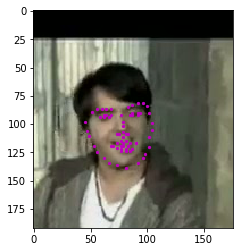

In [30]:
image = mpimg.imread(os.path.join('data/training/', image_name))
plt.imshow(image)
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='m')

In [31]:
# Adapted from: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, path_base, transform=None):
        self.keypoints_frame = pd.read_csv(csv_file)
        self.path_base = path_base
        self.transform = transform
        
    def __len__(self):
        return len(self.keypoints_frame)
    
    # read images here instead of init to save memory
    def __getitem__(self, idx):
        """
        Returns a dictionary of:
        {"image": image, "keypoints": keypoints}
        """
        
        image_name = self.keypoints_frame.iloc[idx, 0]
        image = mpimg.imread(os.path.join(self.path_base, image_name))
        
        # if image has an alpha color channel (4th), get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
            
        keypoints = self.keypoints_frame.iloc[idx, 1:]
        # change from pandas series to numpy array, reshape to (num_keypoints, 2)
        keypoints = keypoints.values.reshape(-1, 2)
        
        sample = {"image": image, "keypoints": keypoints}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

In [34]:
data_train = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                   path_base='data/training/')

print("No of training data: ", len(data_train))

No of training data:  3462


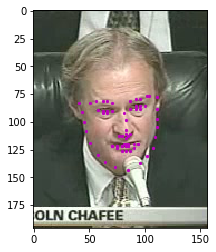

In [35]:
sample = data_train[1]
plt.imshow(sample['image'])
plt.scatter(sample['keypoints'][:, 0], sample['keypoints'][:, 1], s=20, marker='.', c='m')

In [37]:
for idx in range(5):
    sample = data_train[idx]
    print("Image shape: ", sample['image'].shape)

Image shape:  (192, 176, 3)
Image shape:  (196, 157, 3)
Image shape:  (190, 170, 3)
Image shape:  (240, 213, 3)
Image shape:  (191, 184, 3)


The shapes of the images are dissimilar, and we'll need to resize them to the same shape before feeding into the neural network.